# Importing relevant libraries

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder,OneHotEncoder,RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix,classification_report,f1_score

# Reading Files

In [49]:
train_df=pd.read_csv('train.csv')

In [50]:
#Information about the dataset and columns as provided by the IITM

# Input variables:
# 1 last contact date: last contact date
# 2 age (numeric)
# 3 job : type of job
# 4 marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
# 5 education (categorical: "unknown","secondary","primary","tertiary")
# 6 default: has credit in default? (binary: "yes","no")
# 7 balance: average yearly balance, in euros (numeric)
# 8 housing: has housing loan? (binary: "yes","no")
# 9 loan: has personal loan? (binary: "yes","no")
# 10 contact: contact communication type (categorical: "unknown","telephone","cellular")
# 11 duration: last contact duration, in seconds (numeric)
# 12 campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
# 13 pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
# 14 previous: number of contacts performed before this campaign and for this client (numeric)
# 15 poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

# Output variable (desired target):
# 16 target: has the client subscribed a term deposit? (binary: "yes","no")

# Learning about the Data

In [51]:
train_df.head()

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
0,2009-04-17,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no
1,2009-10-11,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN,no
2,2010-11-20,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN,no
3,2009-09-01,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,NaN,no
4,2008-01-29,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,NaN,no


In [52]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  39211 non-null  object
 1   age                39211 non-null  int64 
 2   job                38982 non-null  object
 3   marital            39211 non-null  object
 4   education          37744 non-null  object
 5   default            39211 non-null  object
 6   balance            39211 non-null  int64 
 7   housing            39211 non-null  object
 8   loan               39211 non-null  object
 9   contact            28875 non-null  object
 10  duration           39211 non-null  int64 
 11  campaign           39211 non-null  int64 
 12  pdays              39211 non-null  int64 
 13  previous           39211 non-null  int64 
 14  poutcome           9760 non-null   object
 15  target             39211 non-null  object
dtypes: int64(6), object(10)
memory usage: 4.

In [53]:
train_df.describe()

,age,balance,duration,campaign,pdays,previous
count,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000
mean,42.120247,5441.781719,439.062789,5.108770,72.256051,11.826171
std,12.709352,16365.292065,769.096291,9.890153,160.942593,44.140259
min,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,98.000000,109.000000,1.000000,-1.000000,0.000000
50%,40.000000,549.000000,197.000000,2.000000,-1.000000,0.000000
75%,50.000000,2030.000000,380.000000,4.000000,-1.000000,0.000000
max,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000


### Learning about the null entries in the dataset

In [54]:
train_df.isnull().sum().sum()

np.int64(41483)

In [55]:
train_df.isnull().sum()

last contact date        0
age                      0
job                    229
marital                  0
education             1467
default                  0
balance                  0
housing                  0
loan                     0
contact              10336
duration                 0
campaign                 0
pdays                    0
previous                 0
poutcome             29451
target                   0
dtype: int64

### Imputing the null values

In [56]:
imp_cols=train_df.isnull().sum()[train_df.isnull().sum()>0].index

In [57]:
train_df[imp_cols].head()

,job,education,contact,poutcome
0,blue-collar,secondary,cellular,other
1,technician,secondary,telephone,NaN
2,blue-collar,secondary,cellular,NaN
3,admin.,secondary,telephone,NaN
4,entrepreneur,tertiary,cellular,NaN


In [58]:
for i in imp_cols:
    print(i,"=",train_df[i].dtype)

job = object
education = object
contact = object
poutcome = object


In [59]:
# As both the columns contain object datatype, the best strategy to impute the missing 
# values will be through mode imputer.

In [60]:
Mode_impute=SimpleImputer(strategy='most_frequent')
train_df[imp_cols]=pd.DataFrame(Mode_impute.fit_transform(train_df[imp_cols]),columns=imp_cols,index=train_df.index)

In [61]:
X=train_df[train_df.columns[:-1]]
y=pd.DataFrame(train_df[train_df.columns[-1]])

In [62]:
# Identifying the trends in Data after Grouping therm based on their Label
# Grouping the Object and Integer columns

objcols=X.select_dtypes(include='object').columns.tolist()
numcols=X.select_dtypes(exclude='object').columns.tolist()
objcols.remove('last contact date')

for i in numcols:
    print(i)
    print(X[i].groupby(y['target']).describe().head())
    print()
    print()

for i in objcols:
    print(i)
    print((X[i].groupby(y['target']).value_counts(normalize=True))*100)
    print()
    print()

age
          count       mean        std   min   25%   50%   75%   max
target                                                             
no      33384.0  41.525881  11.503149  18.0  33.0  39.0  49.0  95.0
yes      5827.0  45.525485  17.756105  18.0  32.0  41.0  56.0  95.0


balance
          count          mean           std     min    25%     50%      75%  \
target                                                                        
no      33384.0   3678.747963  12814.590824 -8019.0   74.0   473.0   1623.0   
yes      5827.0  15542.540072  27234.079387 -3058.0  354.0  1604.0  13014.0   

             max  
target            
no      102127.0  
yes     101892.0  


duration
          count         mean          std  min    25%    50%     75%     max
target                                                                      
no      33384.0   328.747963   607.265825  0.0   98.0  172.0   304.0  4918.0
yes      5827.0  1071.077570  1182.646374  8.0  285.0  589.0  1242.5  4916.0




#### This tells us a lot about the data we are handling

Let's say the customers who eventually opt for the product put on sale by the bank are the Y_customers and the ones who don't are N_customers

1) The Y_customers tend to be more old than the N_customers
2) The Y_customers have an average bank balance almost 5 times the N_customers
3) The duration of the last contact for the Y_customers is almost 3 times the duration of N_customers.
4) No of contacts also tells us that the Y_customers were contacted almost 7 times the no of times N_customers were contacted.
5) Mostly the people who opted for the product in the last campaign may also opt for the product in this campaign.
6) The contacts made on telephone have slightly more chances of getting converted into Y_customers.
7) The Jobs column also shows that some professions are more likely to opt for the product than others.

### Checking for outliers

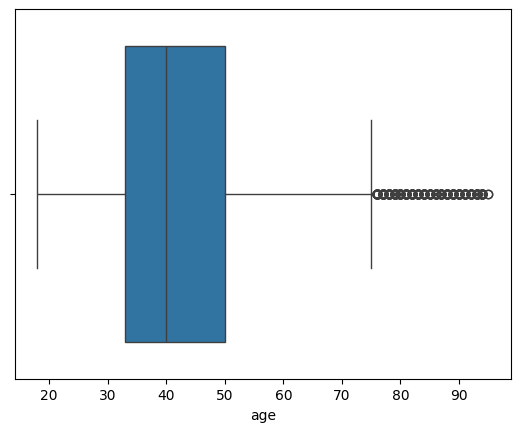

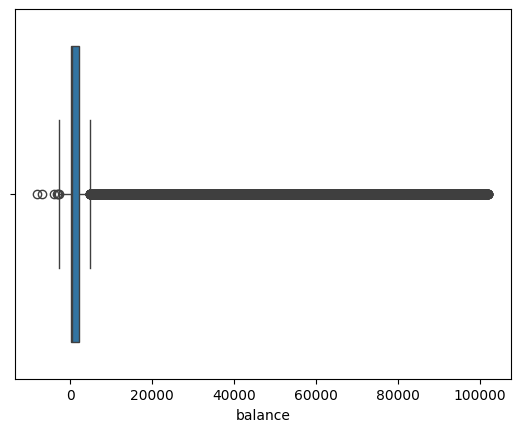

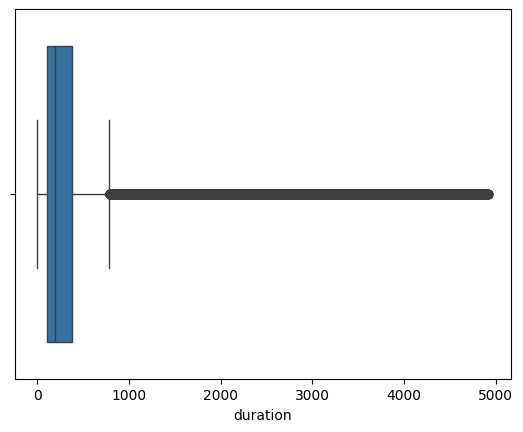

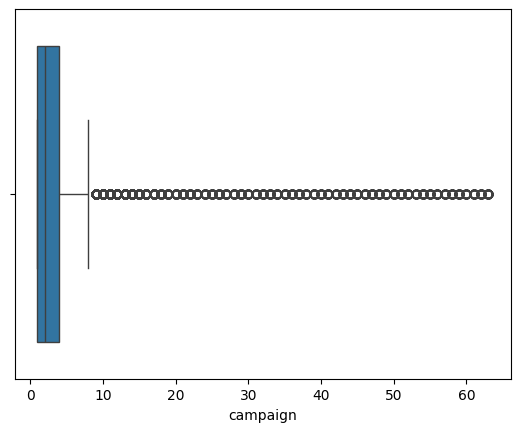

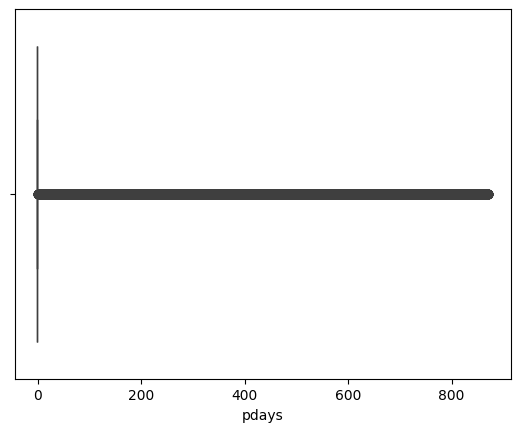

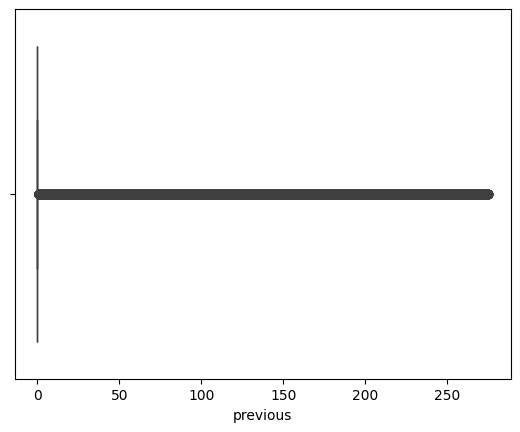

In [63]:
for i in numcols:
    sns.boxplot(data=X,x=i)
    plt.show()

We see that removing the outliers will not be a practical approach as the outliers are a significant percentage of the population and removing them will remove some possibly useful data.

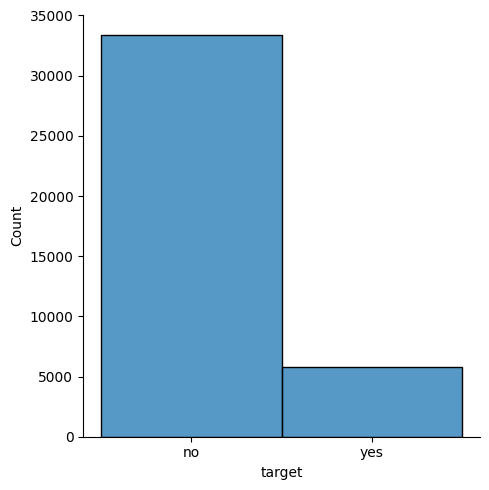

In [64]:
sns.displot(data=train_df,x='target')

#### We can Infer

The dataset we are handling is a very imbalanced dataset as the no of no entries clearly outweigh the no of yes entries by a huge margin.

# Feature Engineering

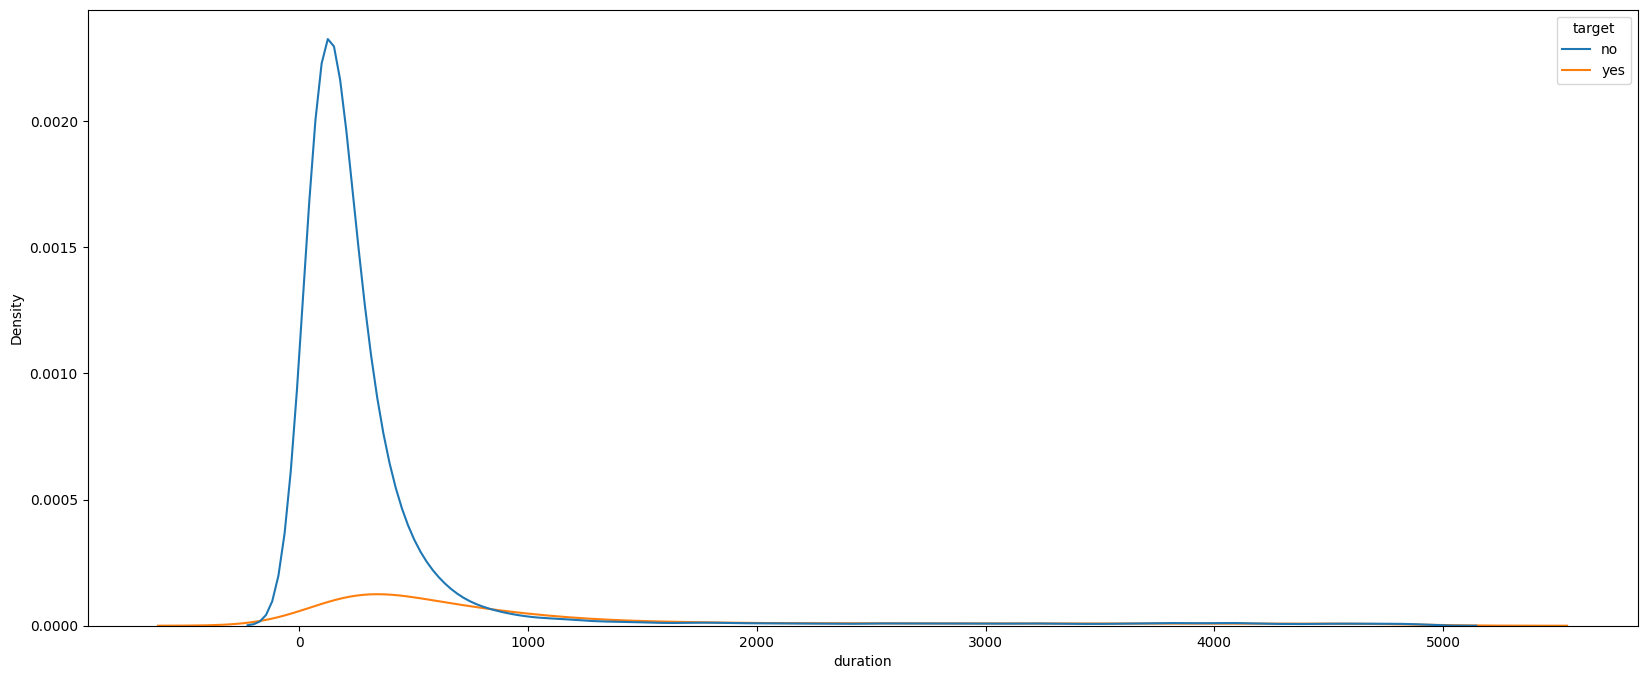

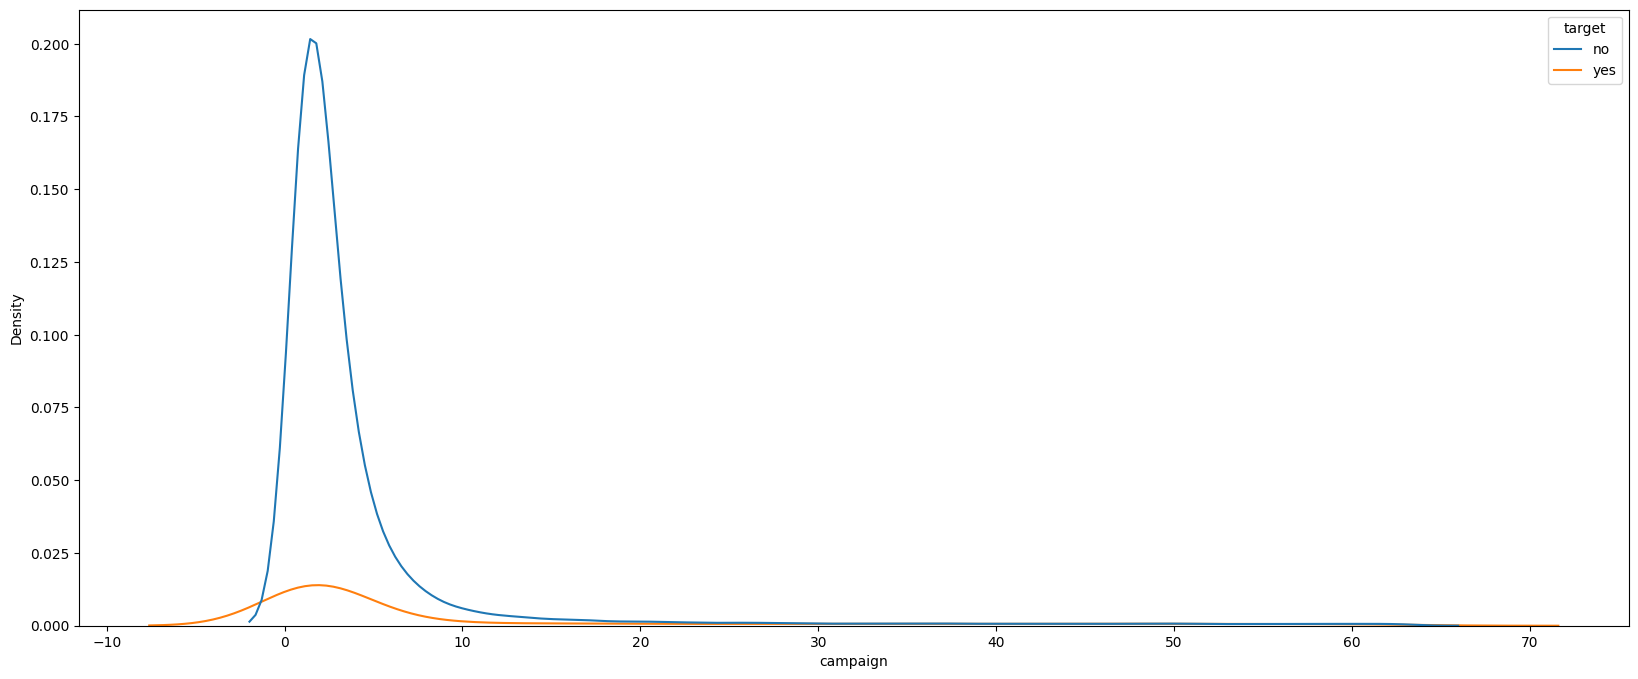

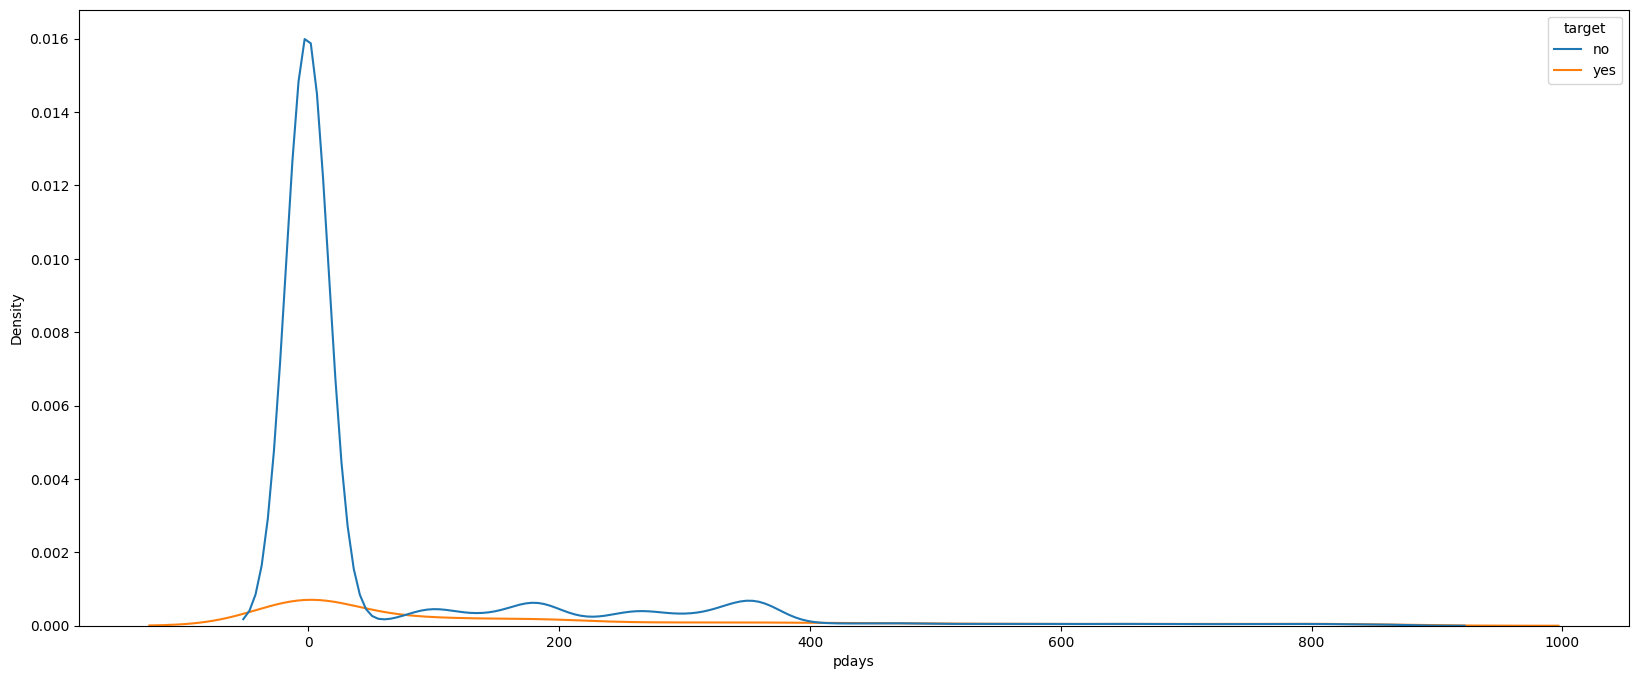

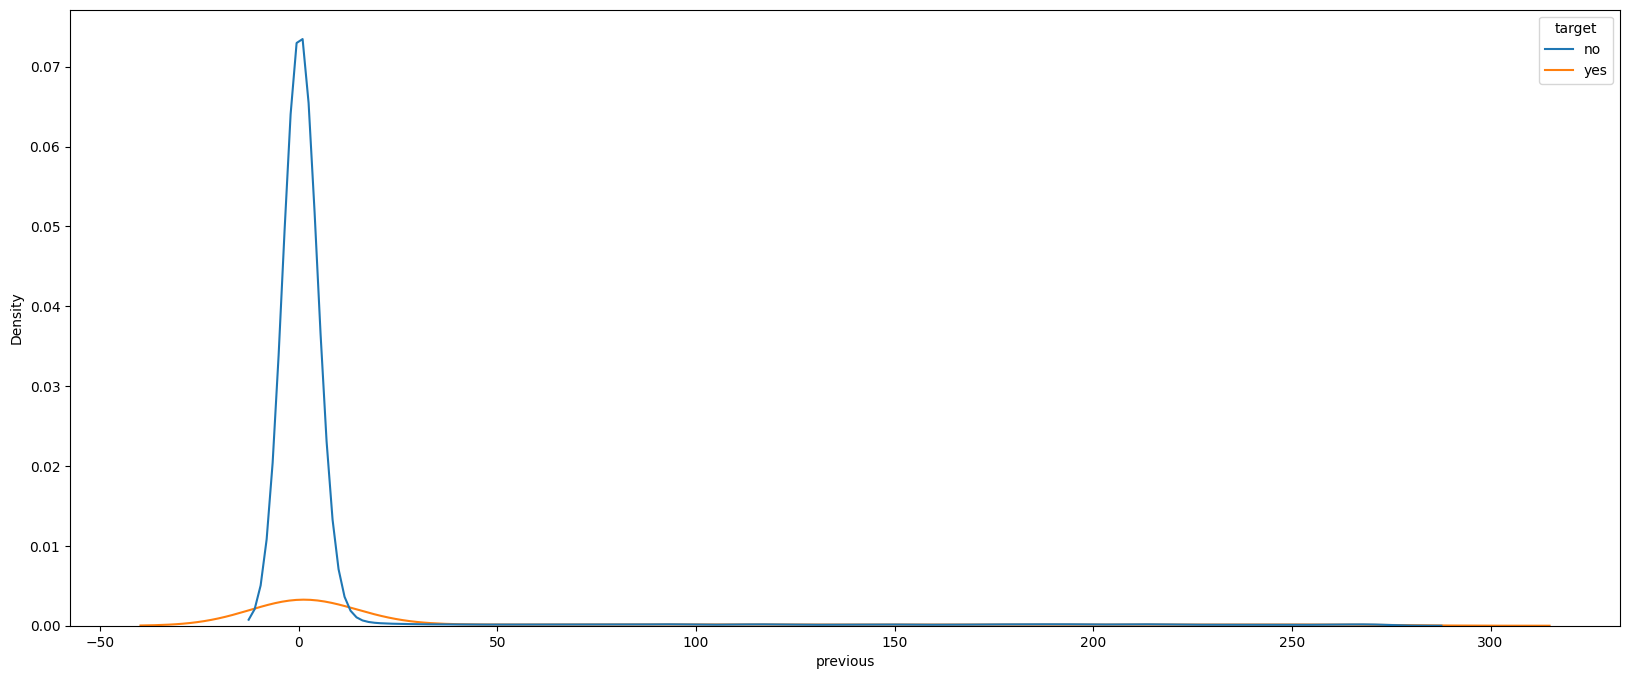

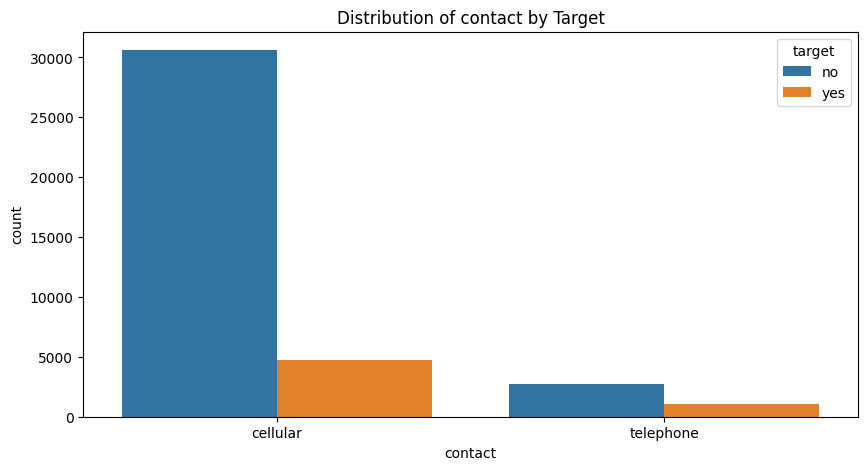

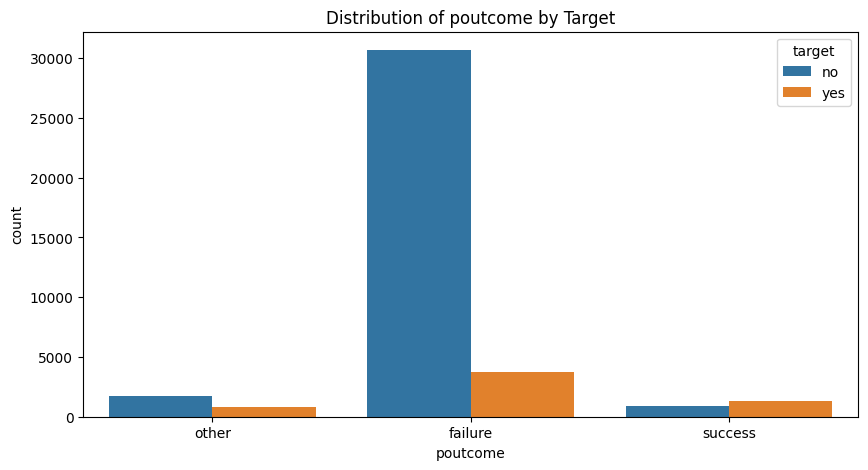

In [65]:
ob_col=['contact','poutcome']
cols=['duration','campaign','pdays','previous',]
for i in cols:
    plt.figure(figsize=(20,8))
    sns.kdeplot(data=X.join(y),x=i,hue='target')
    plt.show()

for col in ob_col:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=X.join(y), x=col, hue='target') 
    plt.title(f'Distribution of {col} by Target')
    plt.show()

#### We see that the numerical columns are too skewed to the right

In [66]:
eng_cols=[]

X['duration_log'] = np.log(X['duration'] + 1)

X['campaign_inv'] = 1/(X['campaign'])

X['previous_log'] = np.log(X['previous']+2)

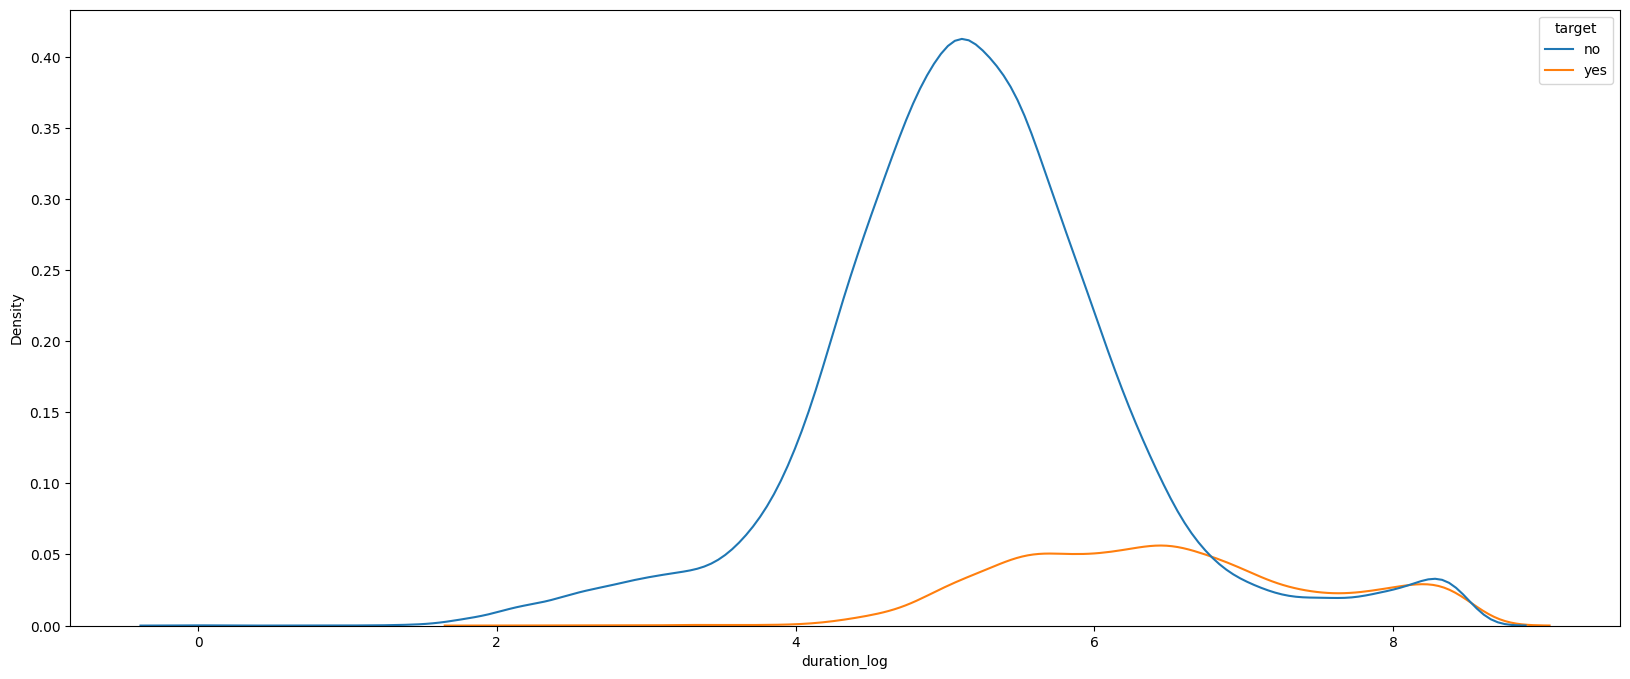

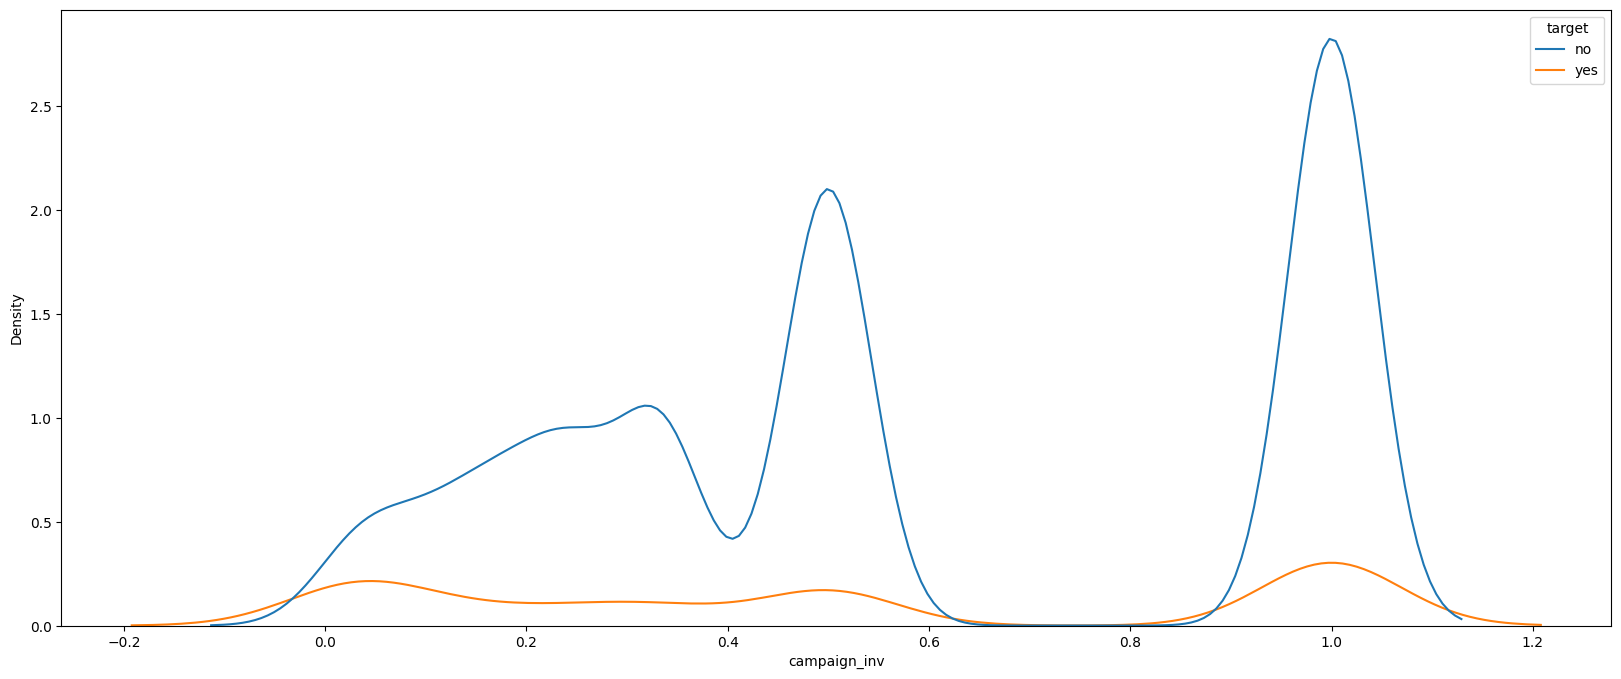

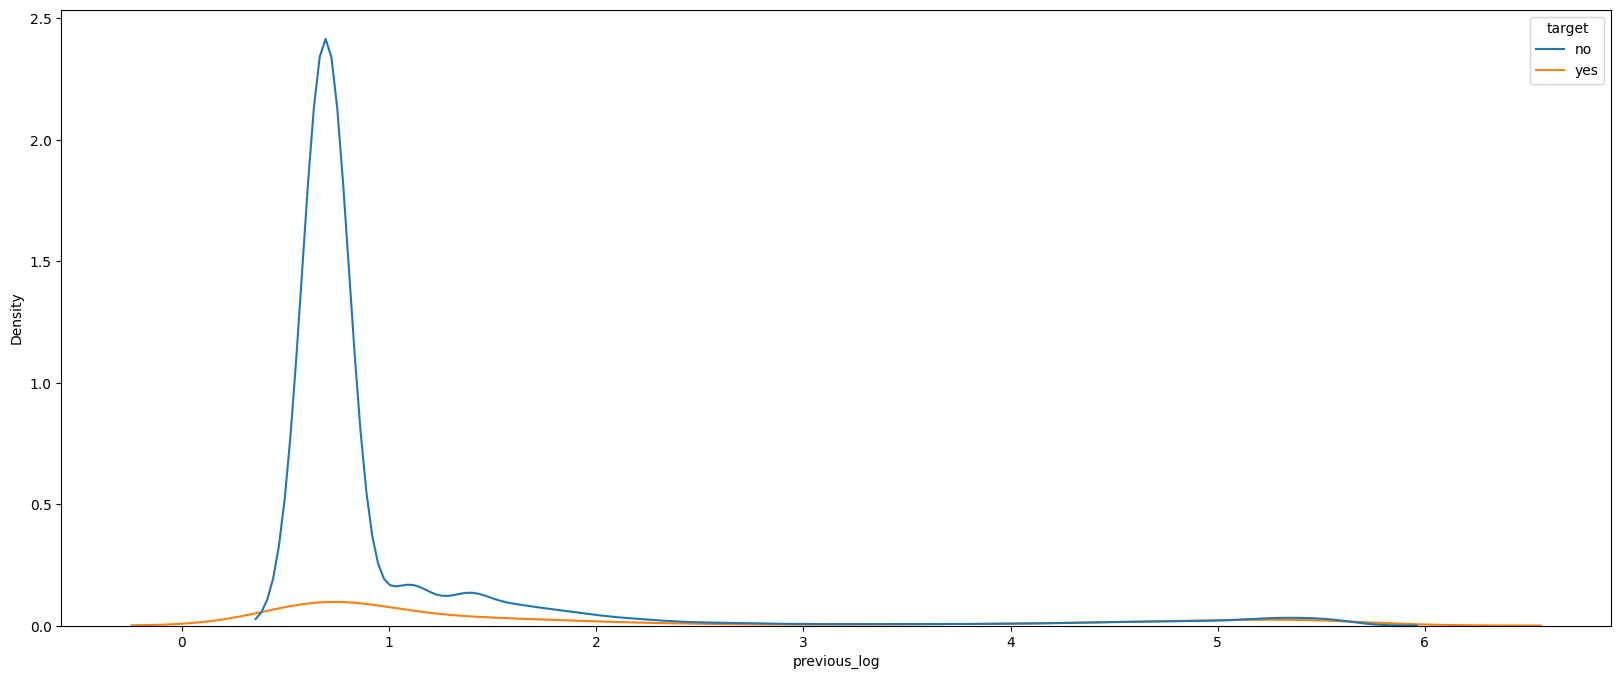

In [67]:
cols=['duration_log','campaign_inv','previous_log',]
for i in cols:
    plt.figure(figsize=(20,8))
    sns.kdeplot(data=X.join(y),x=i,hue='target')
    plt.show()

In [68]:
def age_binner(age):
    if age < 30:
        return 'Young'
    elif 30 <= age < 60:
        return 'Middle-aged'
    else:
        return 'Old'
X['age_binned'] = X['age'].map(age_binner)
eng_cols.append('age_binned')


X['ongoing_loan']=((X['housing']=='yes')|(X['loan']=='yes')).astype(int)
eng_cols.append('ongoing_loan')

def balance_binner(balance):
    if balance <= 0:
        return 'Negative'
    elif 0<= balance < 3000:
        return 'Low'
    elif 3000 <= balance < 10000:
        return 'Average'
    elif 10000<= balance < 50000:
        return 'Upper Average'
    else:
        return 'High'
X['balance_binned'] = X['balance'].map(balance_binner)
eng_cols.append('balance_binned')

X['financially_weak']=((X['balance']<1000)&X['ongoing_loan']==1 ).astype(int)
X['financially_strong']=((X['balance']>3000)&X['ongoing_loan']==0 ).astype(int)
eng_cols.append('financially_weak')
eng_cols.append('financially_strong')

X['risky_customers']=((X['default']=='yes')&(X['ongoing_loan']==1)).astype(int)
eng_cols.append('risky_customers')

def campaign_binner(no):
    if no <= 5:
        return 'Short'
    else:
        return 'Long'
X['campaign_binned'] = X['campaign'].map(campaign_binner)
X['previous_binned'] = X['previous'].map(campaign_binner)
eng_cols.append('campaign_binned')
eng_cols.append('previous_binned')

def duration_binner(days):
    if days <= 150:
        return 'Short'
    else:
        return 'Long'

X['duration_binned'] = X['duration'].map(duration_binner)
eng_cols.append('duration_binned')

X['possibly_interested']=(((X['campaign']>1)|(X['previous']>1))&(X['duration']>100))
eng_cols.append('possibly_interested')

X['ageXmarital']=X['age_binned']+" "+X['marital']
eng_cols.append('ageXmarital')

def job_binner(job):
    if job in ['blue-collar','technician']:
        return 'Labour_class'
    elif job in ['unemployed','student','retired','housemaid']:
        return 'Non-Working'
    elif job in ['admin.','management','services']:
        return 'White_collar'
    else:
        return 'self_employed'

X['job_binned'] = X['job'].map(job_binner)
eng_cols.append('job_binned')



X['last contact date'] = pd.to_datetime(X['last contact date'])
X['day'] = X['last contact date'].dt.day_name()  
X['date'] = X['last contact date'].dt.day        
X['month'] = X['last contact date'].dt.month


def day_binner(day):
    if day in ['Saturday','Sunday']:
        return 'Weekend'
    else:
        return 'Weekday'

X['day_binned'] = X['day'].map(day_binner)
eng_cols.append('day_binned')

def date_binner(date):
    if date < 10:
        return 'Month_start'
    elif 10<date<25:
        return 'Mid_month'
    else:
        return 'Month_end'

X['date_binned'] = X['date'].map(date_binner)
eng_cols.append('date_binned')

def month_binner(month):
    if month <= 3:
        return 'First_Quarter'
    elif 4<=month<7:
        return 'Second_Quarter'
    elif 7<=month<10:
        return 'Third_Quarter'
    else:
        return 'Fourth_Quarter'

X['month_binned'] = X['month'].map(month_binner)
eng_cols.append('month_binned')

eng_cols.append('day')
eng_cols.append('date')
eng_cols.append('month')

In [69]:
drp_cols=['duration','campaign','previous','last contact date']
X.drop(drp_cols,axis=1,inplace=True)

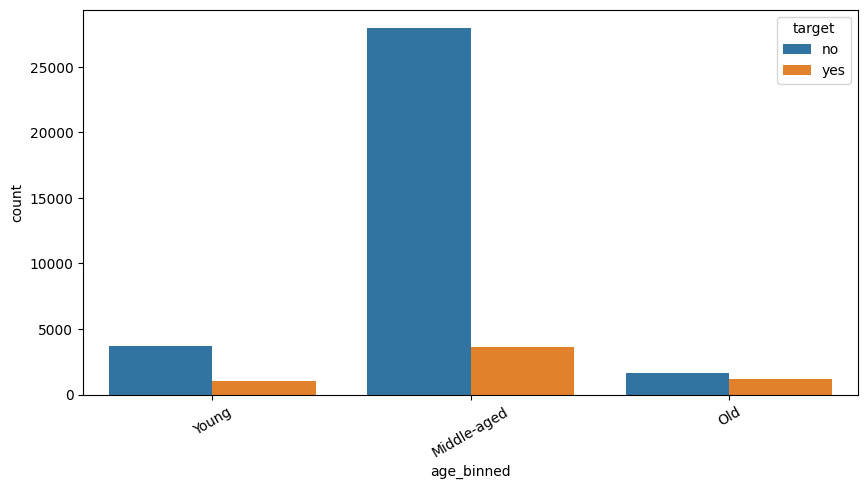

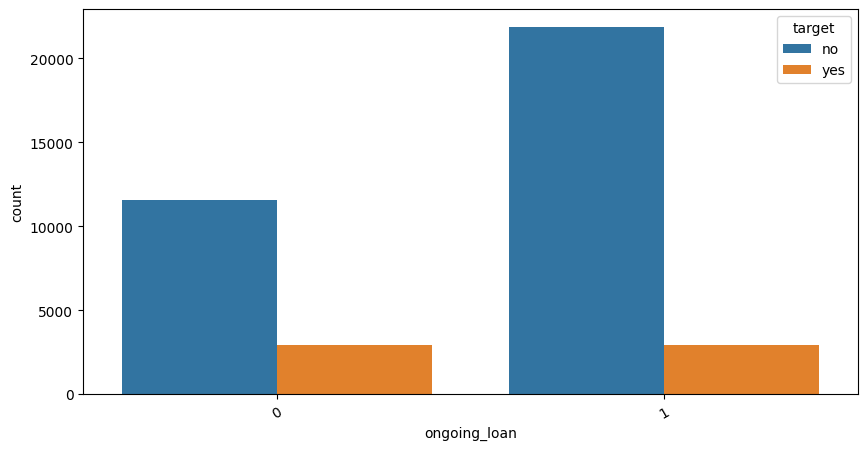

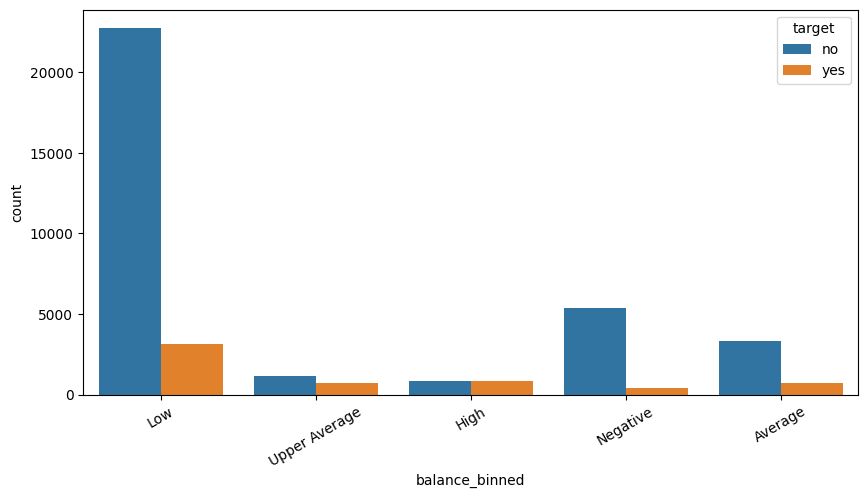

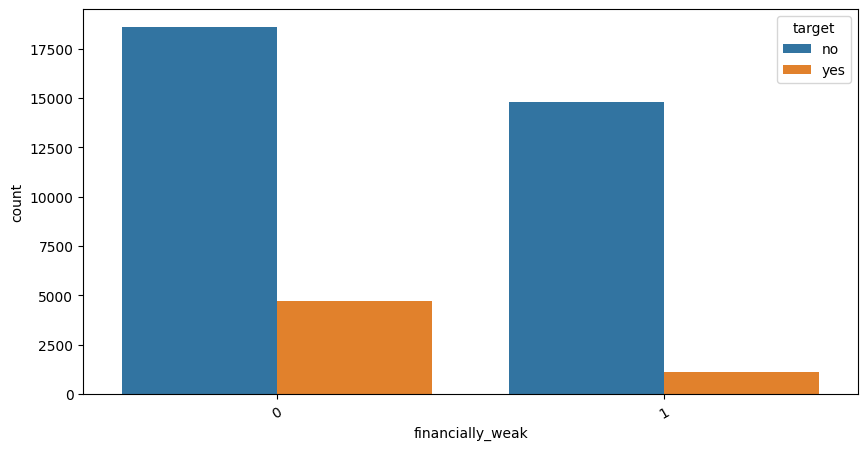

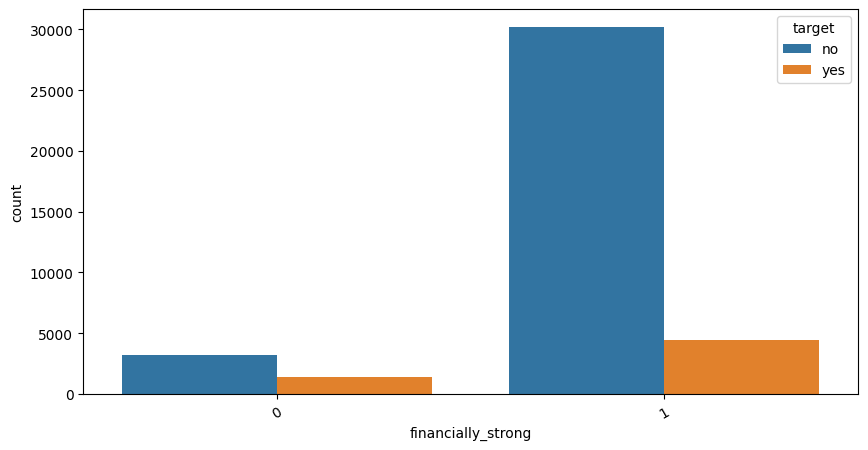

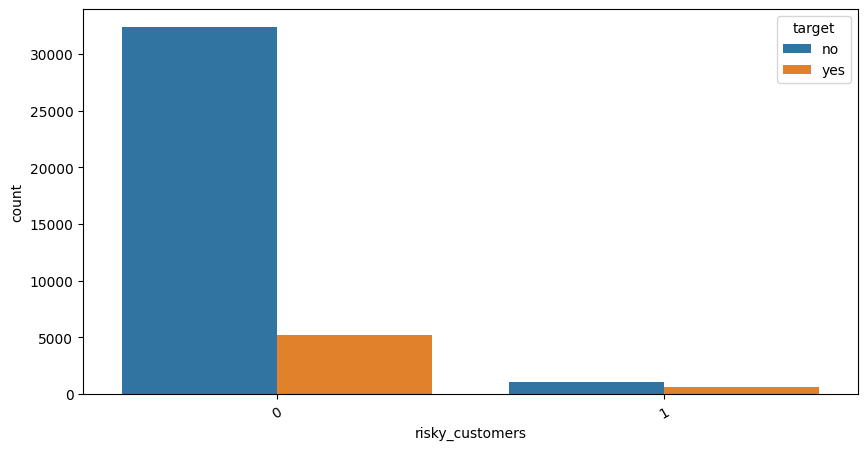

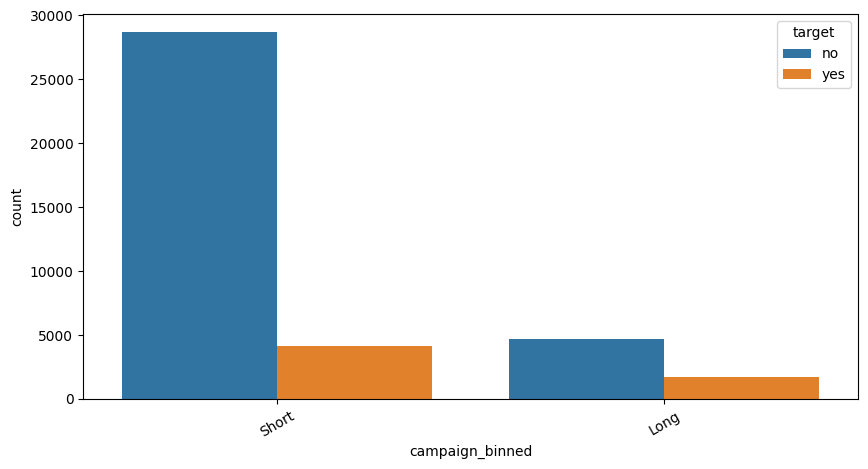

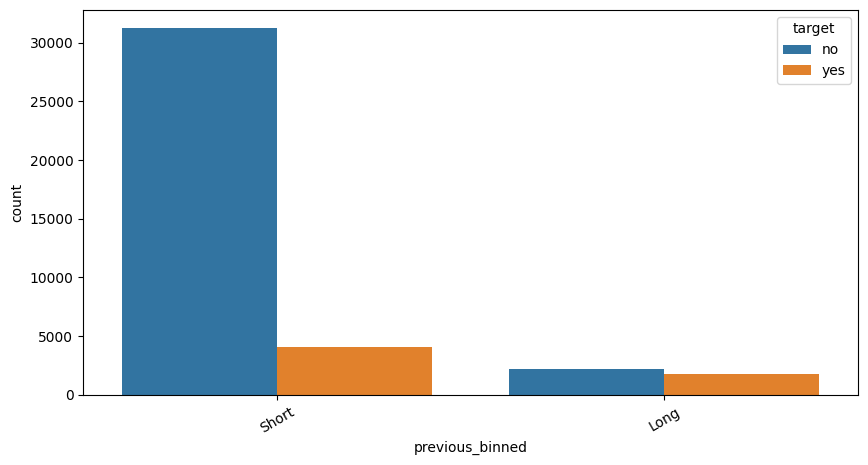

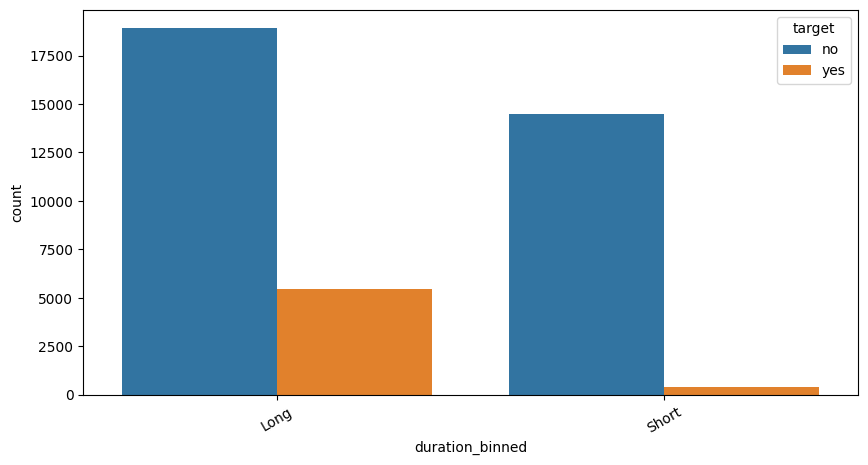

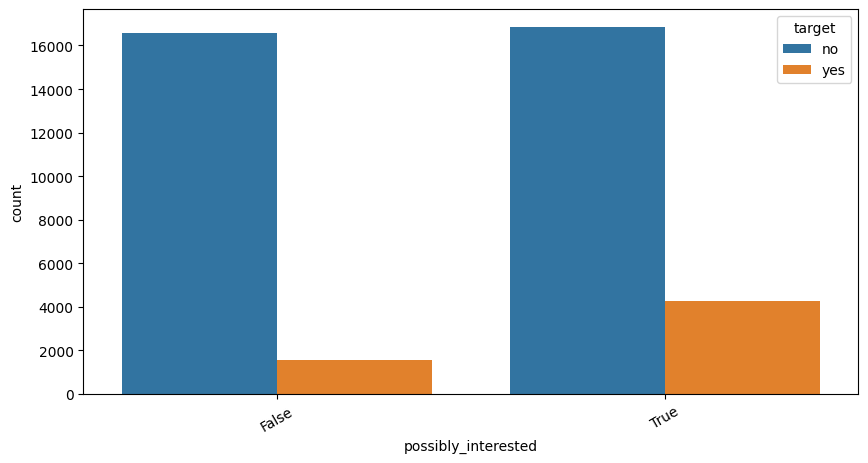

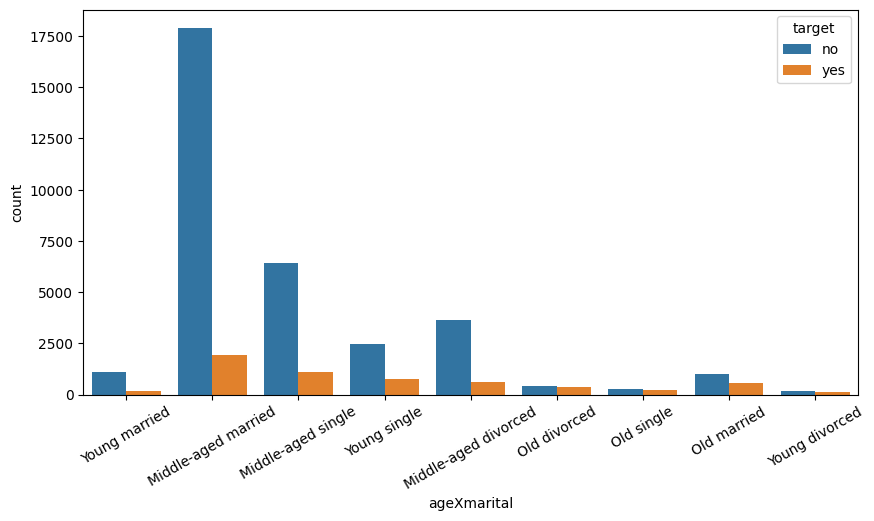

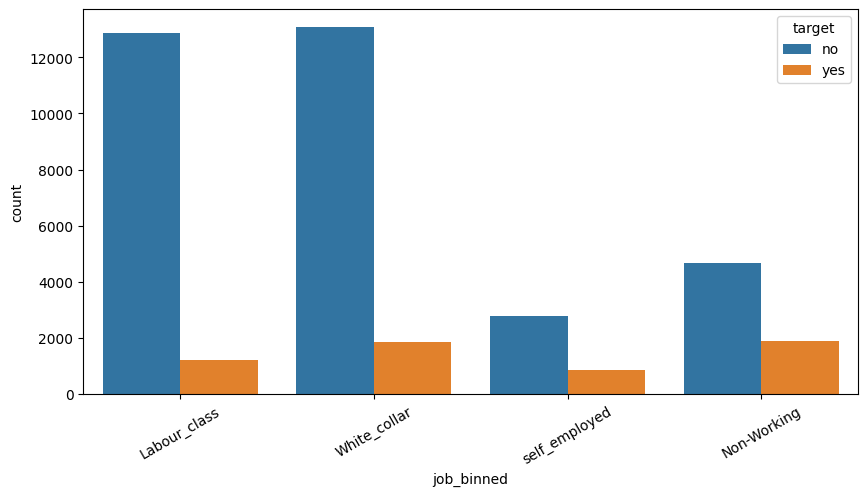

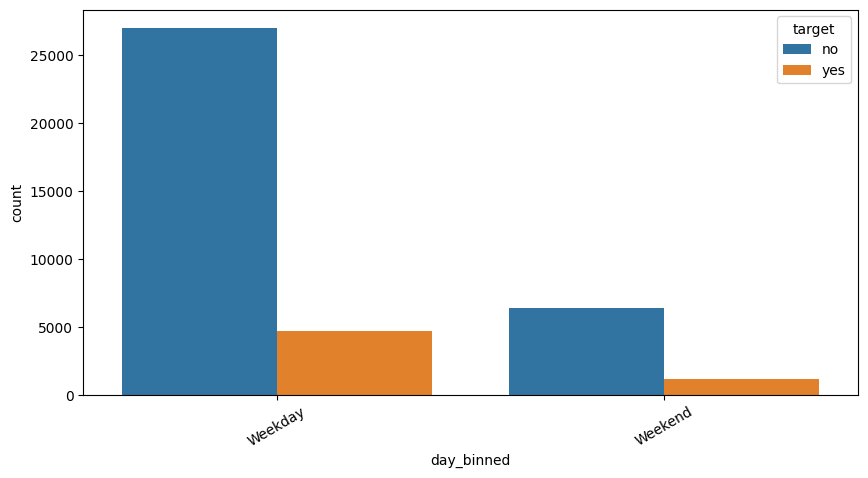

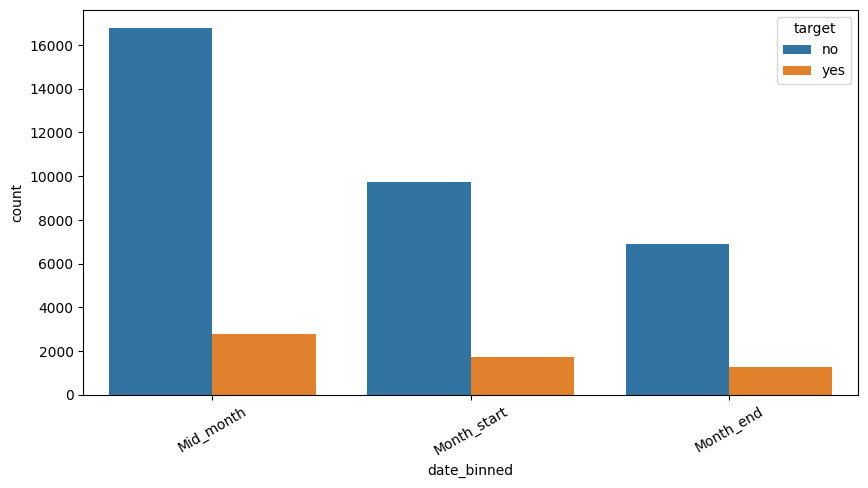

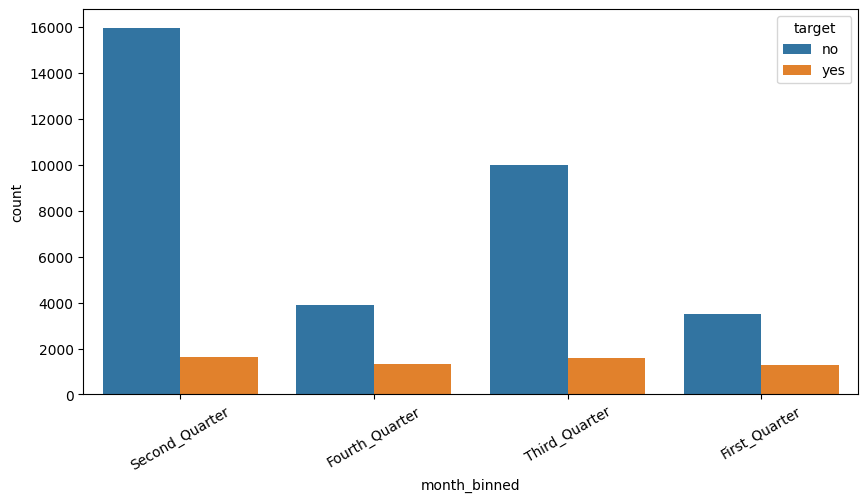

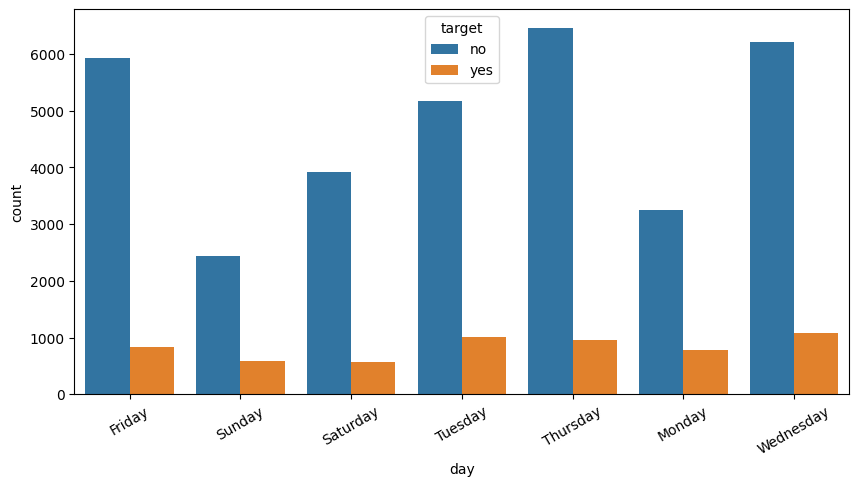

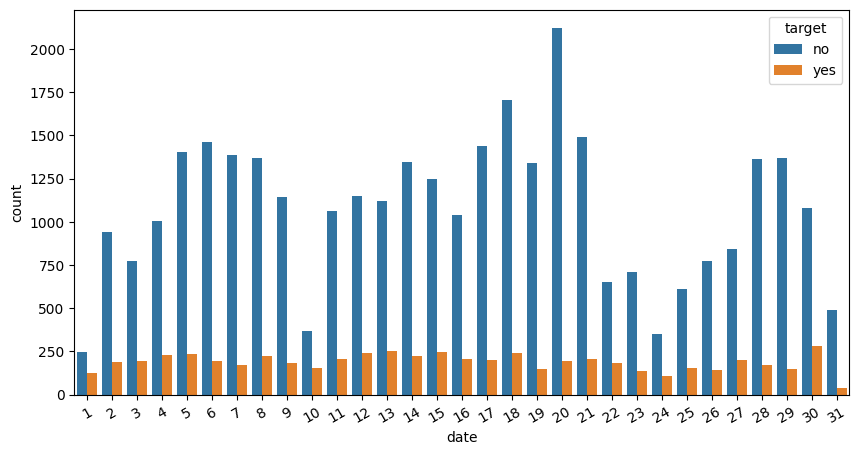

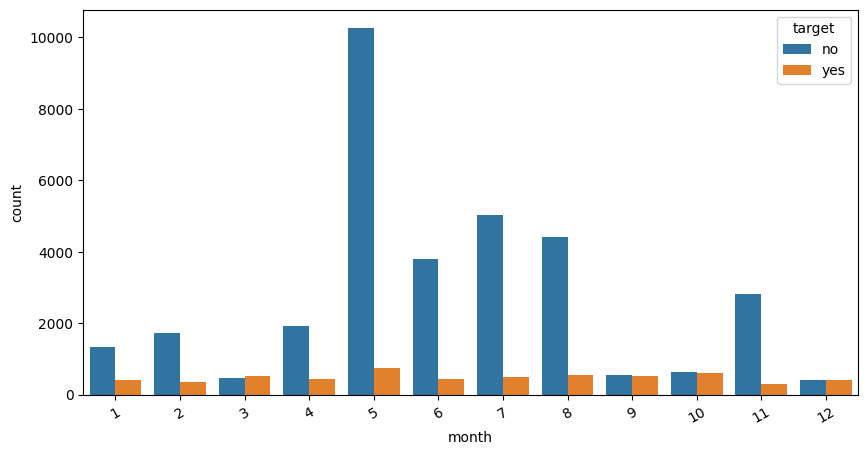

In [70]:
for col in eng_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=X.join(y), x=col, hue='target')
    plt.xticks(rotation=30)
    plt.show()

#### We see that the engineered columns showcase considerable correlation with the label column

# Preprocessing

In [71]:
# Grouping the Object and Integer columns

objcols=X.select_dtypes(include='object').columns.tolist()
numcols=X.select_dtypes(exclude='object').columns.tolist()

In [72]:
#Grouping the columns into one hot and ordinal categories

oh_cols=X[objcols].nunique()[X[objcols].nunique()>=3].index.tolist()
ord_cols=[x for x in objcols if x not in oh_cols]

In [73]:
oh_encoder=OneHotEncoder(sparse_output=False)
ord_encoder=OrdinalEncoder()

In [74]:
#Applying One Hot encoding and then grouping the Datasets
oh_df_train=pd.DataFrame(oh_encoder.fit_transform(X[oh_cols]),columns=oh_encoder.get_feature_names_out(),index=X.index)
X=X.join(oh_df_train).drop(oh_cols,axis=1)

In [75]:
# Applying ordinal encoding
X[ord_cols]=pd.DataFrame(ord_encoder.fit_transform(X[ord_cols]),columns=ord_cols,index=X.index)

In [76]:
#Label encoding the target variable
lb_encoder=LabelEncoder()
y=pd.DataFrame(lb_encoder.fit_transform(y),index=X.index)

In [77]:
#revising the type of columns after appying encoding

objcols=X.select_dtypes(include='object').columns.tolist()
numcols=X.select_dtypes(exclude='object').columns.tolist()

In [78]:
xtrain,xtest,ytrain,ytest=train_test_split(X,y,train_size=0.8,random_state=8)

In [79]:
# pca=PCA(n_components=30)
# pca_train=pd.DataFrame(pca.fit_transform(xtrain))
# pca_test=pd.DataFrame(pca.transform(xtest))
# test_df_pca=pd.DataFrame(pca.transform(test_df))

In [80]:
pd.set_option('display.max_rows', None)
correlation=pd.DataFrame(xtrain.join(ytrain).corr()[0][:-1])
print(abs(correlation).sort_values(by=0,ascending=False))

                                         0
duration_log                      0.402697
previous_log                      0.321465
poutcome_failure                  0.314267
poutcome_success                  0.307065
previous_binned                   0.291086
duration_binned                   0.269893
pdays                             0.262688
balance                           0.261773
balance_binned_High               0.215968
age_binned_Old                    0.213721
age_binned_Middle-aged            0.196415
financially_weak                  0.181914
job_binned_Non-Working            0.175322
possibly_interested               0.161027
default                           0.160511
financially_strong                0.159137
balance_binned_Upper Average      0.152209
campaign_binned                   0.147096
ageXmarital_Middle-aged married   0.146609
month_binned_Second_Quarter       0.143380
risky_customers                   0.141563
job_binned_Labour_class           0.132821
ageXmarital

In [81]:
train_cols=correlation[abs(correlation)>abs(correlation).quantile(0.0)].dropna().index.to_list()
print(len(train_cols))

75


In [82]:
ytrain=np.array(ytrain[0])
ytest=np.array(ytest[0])

In [83]:
# sel_cols=['duration_log', 'campaign_inv', 'previous_log', 'ongoing_loan',
#        'financially_weak', 'financially_strong', 'risky_customers',
#        'campaign_binned', 'previous_binned', 'duration_binned',
#        'possibly_interested', 'job_admin.', 'job_blue-collar',
#        'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
#        'job_self-employed', 'job_services', 'job_student', 'job_technician',
#        'job_unemployed', 'marital_divorced', 'marital_married',
#        'marital_single', 'education_primary', 'education_secondary',
#        'education_tertiary', 'poutcome_failure', 'poutcome_other',
#        'poutcome_success', 'age_binned_Middle-aged', 'age_binned_Old',
#        'age_binned_Young', 'balance_binned_Average', 'balance_binned_High',
#        'balance_binned_Low', 'balance_binned_Negative',
#        'balance_binned_Upper Average', 'ageXmarital_Middle-aged divorced',
#        'ageXmarital_Middle-aged married', 'ageXmarital_Middle-aged single',
#        'ageXmarital_Old divorced', 'ageXmarital_Old married',
#        'ageXmarital_Old single', 'ageXmarital_Young divorced',
#        'ageXmarital_Young married', 'ageXmarital_Young single',
#        'job_binned_Labour_class', 'job_binned_Non-Working',
#        'job_binned_White_collar', 'job_binned_self_employed']

# Model Training

              precision    recall  f1-score   support

           0       0.96      0.85      0.90      6718
           1       0.47      0.78      0.59      1125

    accuracy                           0.84      7843
   macro avg       0.72      0.82      0.75      7843
weighted avg       0.89      0.84      0.86      7843

F1 Score (macro): 0.7465585413191129


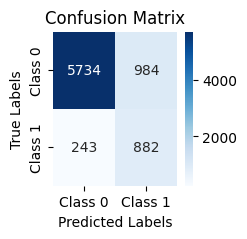

In [84]:
#Random Forest with only class weight balanced

rf= RandomForestClassifier(class_weight='balanced',random_state=42)
param_grid = {
    'n_estimators': [50,100,200],  
    'max_depth': [6,9,12],  
    'min_samples_split': [2, 5],          
    'criterion': ['gini','entropy','log_loss'],
    'bootstrap': [True, False]                
}

model = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    scoring='f1_macro',
    cv=3,  
    random_state=42,
    n_jobs=-1  
)


preprocessor = ColumnTransformer(
    transformers=[
        ('rbs',RobustScaler(),numcols)
    ]
)

rfclf_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', model)
])

rfclf_pipeline.fit(xtrain, ytrain)

ypred = rfclf_pipeline.predict(xtest)
print(classification_report(ytest, ypred))
print("F1 Score (macro):", f1_score(ytest, ypred, average='macro'))
rfclf_f1 = f1_score(ytest, ypred, average='macro')
cm=confusion_matrix(ytest,ypred)
plt.figure(figsize=(2, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

              precision    recall  f1-score   support

           0       0.96      0.87      0.91      6718
           1       0.51      0.81      0.62      1125

    accuracy                           0.86      7843
   macro avg       0.73      0.84      0.77      7843
weighted avg       0.90      0.86      0.87      7843

F1 Score (macro): 0.7672722068627162


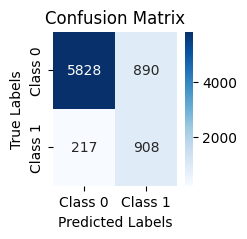

In [85]:
xgbclf = XGBClassifier(
    scale_pos_weight=len(ytrain) / (2 * sum(ytrain)),
    random_state=132
)

param_grid = {
    'n_estimators': [700,200,500],
    'max_depth': [3, 6, 9,12],
    'learning_rate': [0.001,0.002,0.01, 0.1, 0.2,0.5],
    'subsample': [0.2,0.5, 0.7, 1],
    'colsample_bytree': [0.2,0.5, 0.7, 1],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3],
}

model = RandomizedSearchCV(
    estimator=xgbclf,
    param_distributions=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='f1_macro',
    random_state=42
)

preprocessor = ColumnTransformer(
    transformers=[
        ('rbs',RobustScaler(),numcols)
    ]
)

xgbclf_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', model)
])

xgbclf_pipeline.fit(xtrain, ytrain)

ypred = xgbclf_pipeline.predict(xtest)
print(classification_report(ytest, ypred))
print("F1 Score (macro):", f1_score(ytest, ypred, average='macro'))
xgbclf_f1 = f1_score(ytest, ypred, average='macro')
cm=confusion_matrix(ytest,ypred)
plt.figure(figsize=(2, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      6718
           1       0.56      0.43      0.49      1125

    accuracy                           0.87      7843
   macro avg       0.73      0.69      0.71      7843
weighted avg       0.86      0.87      0.86      7843

F1 Score (macro): 0.7061062283648268


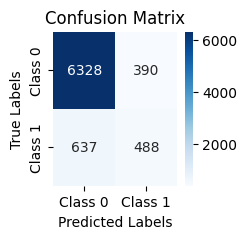

In [86]:
bagging_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    random_state=42,
)

param_grid = {
    'estimator__max_depth': [3, 6, 9, 12],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4],
    'n_estimators': [10, 50, 100, 200],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
    'bootstrap': [True, False]
}

model = RandomizedSearchCV(
    estimator=bagging_clf,
    param_distributions=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='f1_macro',
    random_state=42
)

preprocessor = ColumnTransformer(
    transformers=[
        ('rbs', RobustScaler(), numcols)
    ]
)

bclf_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', model)
])

bclf_pipeline.fit(xtrain, ytrain)

ypred = bclf_pipeline.predict(xtest)
print(classification_report(ytest, ypred))
print("F1 Score (macro):", f1_score(ytest, ypred, average='macro'))
bgclf_f1 = f1_score(ytest, ypred, average='macro')
cm=confusion_matrix(ytest,ypred)
plt.figure(figsize=(2, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

<BarContainer object of 3 artists>

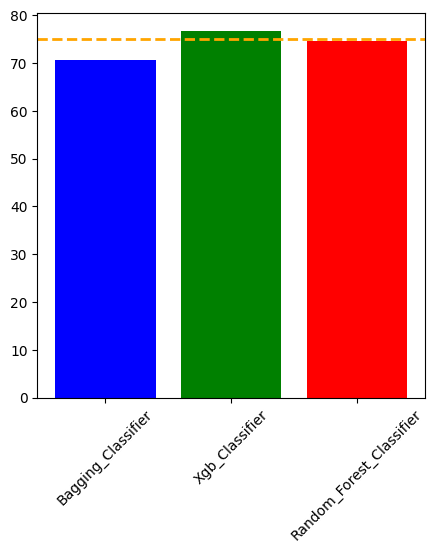

In [87]:
model_names = ['Bagging_Classifier', 'Xgb_Classifier', 'Random_Forest_Classifier']
f1_scores = [bgclf_f1, xgbclf_f1, rfclf_f1]  
for i in range(len(f1_scores)):
    f1_scores[i]=f1_scores[i]*100
plt.figure(figsize=(5, 5))
plt.axhline(y=75, color='orange', linestyle='--', linewidth=2, label='Threshold = 75')
plt.xticks(rotation=45)
plt.bar(model_names, f1_scores, color=['blue', 'green', 'red'])

In [88]:
'''THE END'''

'THE END'